In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from utils import Aircraft

# Basic flight

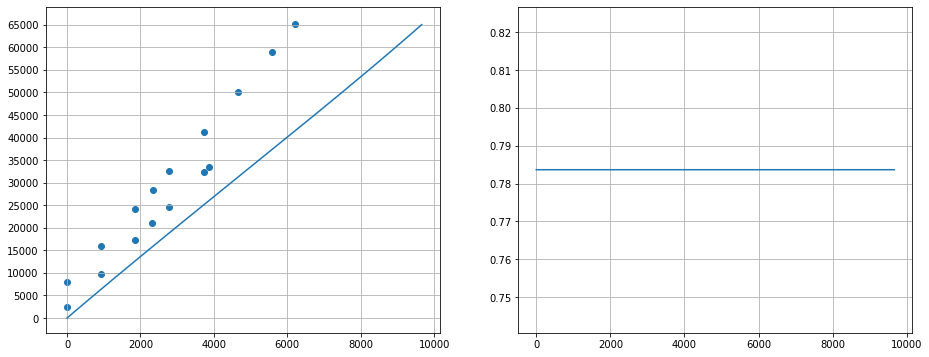

In [2]:
notesData = '-13.779527559055055, 2508.960573476652; 930.1181102362204, 9677.419354838668; 1860.236220472441, 17275.985663082407; 2321.850393700787, 21003.584229390646; 2790.354330708661, 24587.81362007164; 3727.36220472441, 32329.749103942624; 3861.712598425197, 33548.38709677418; 0, 7956.98924731178; 926.6732283464567, 15985.663082437255; 1853.3464566929133, 24157.706093189918; 2328.740157480315, 28458.78136200717; 2790.354330708661, 32616.4874551971; 3727.36220472441, 41290.32258064514; 4664.370078740157, 50179.21146953403; 5594.488188976376, 58996.415770609296; 6204.232283464566, 65089.605734767'
notesSFB, notesFB = zip(*[(float(datapoint.split(', ')[0]), float(datapoint.split(', ')[1])) for datapoint in notesData.split('; ')])

timestep = 1 # s

# Analysis variables
vRat = 1 # Ratio of EAS to optimal EAS
initCruiseAlt = 30000
W_P = 40_000
W_F = 74_000

# vCruise = 256
# MCruise = 0.85
# LDCruise = 21

aircraftSpecs = {'W_E':106_000, 'W_MP':40_000, 'W_MTO':220_000, 'W_P':W_P, 'W_F':W_F, # Weight specs
                    'maxPass':240, 'MPRange':12_000, 'W_F_MP':74_000, 'SWing':315, # Other aircraft specs
                    'rEgnine':45, 'thetEngine':6, 'effComp':0.9, 'effTurb':0.9, 'FPREngine':1.45, 'effFan':0.92, 'effTransfer':0.9, 'LCVFuel':42.7e6, # Engine
                    'timestep':timestep, 'k':0.015, 'c1':0.3, 'c2':1.0, 'K1':0.0125, 'K2':0.0446, 'vRat':vRat} # Model parameters

aircraft = Aircraft(aircraftSpecs)

altitudes = initCruiseAlt * np.ones(10)

distances = []
fuelBurn = []
machs = []
Hs = []
LDRats = []
weights = []
effOveralls = []
effProps = []

while aircraft.W_F > 0:
    aircraft.updateAllFlightValues(initCruiseAlt, ft=True, MOvrd=0.85)
    distances.append(aircraft.s/1000)
    fuelBurn.append(aircraft.W_FB)
    machs.append(aircraft.M)
    Hs.append(aircraft.H)
    LDRats.append(1/aircraft.beta)
    weights.append(aircraft.W)
    effOveralls.append(aircraft.effOverall)
    effProps.append(aircraft.effProp)

plt.figure(figsize=[24,6])

plt.subplot(1,3,1)
plt.plot(distances, fuelBurn)
plt.scatter(notesSFB, notesFB)
plt.yticks(np.arange(0,max(fuelBurn),5000))
plt.grid()

plt.subplot(1,3,2)
plt.plot(distances, effProps)
plt.grid()

plt.show()



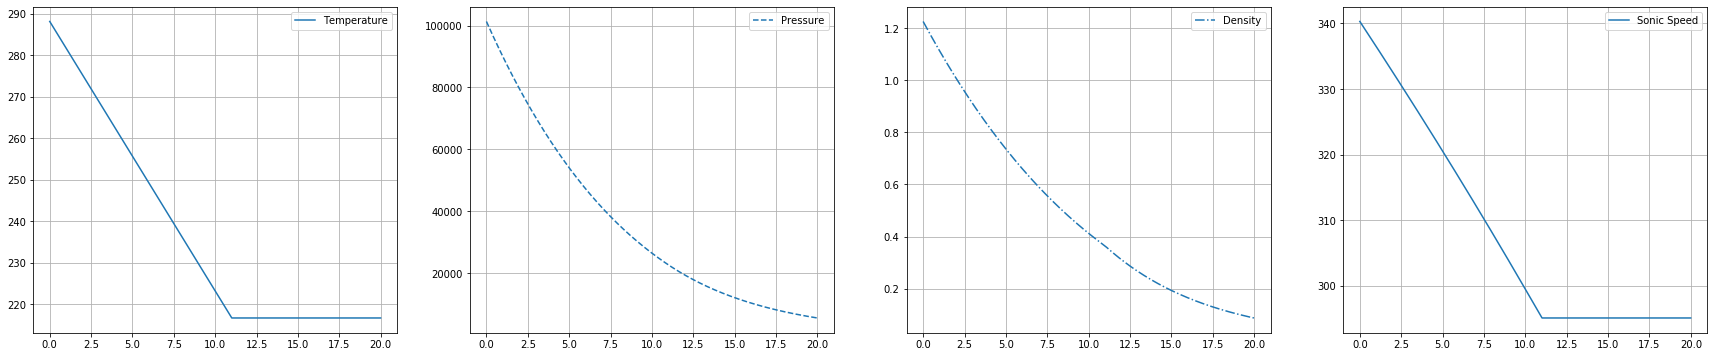

216.65 5482.699821515687 0.0881844697552786


In [38]:
T_sl = 288.15
p_sl = 101325
rho_sl = 1.225
a_sl = 340.3

TRat = []
pRat = []
rhoRat = []
aRat = []

hRange = np.arange(0,20,0.01)

for h in hRange:
    if h <= 11:
        T = T_sl - 6.5*h
        TRat.append(T)

        pRat.append((T/T_sl)**5.256 * p_sl)
        rhoRat.append((T/T_sl)**4.256 * rho_sl)
        aRat.append((T/T_sl)**0.5 * a_sl)
    elif h <= 20:
        T = 216.65
        TRat.append(T)

        tropRat = np.exp(-0.1577*(h-11))
        pRat.append(tropRat * 22631)
        rhoRat.append(tropRat * 0.364)
        aRat.append((T/T_sl)**0.5*a_sl)

plt.figure(figsize=[30,6])
plt.subplot(1,4,1)
plt.plot(hRange, TRat, label='Temperature')
plt.legend()
plt.grid()
plt.subplot(1,4,2)
plt.plot(hRange, pRat, label='Pressure', linestyle='--')
plt.legend()
plt.grid()
plt.subplot(1,4,3)
plt.plot(hRange, rhoRat, label='Density', linestyle='-.')
plt.legend()
plt.grid()
plt.subplot(1,4,4)
plt.plot(hRange, aRat, label='Sonic Speed')
plt.legend()
plt.grid()

plt.show()

print(TRat[-1], pRat[-1], rhoRat[-1])